Ultimate Code

In [1]:
# Files path
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import imutils

mypath = '/content/drive/MyDrive/Photo Management/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles

['KA555ZG.jpg',
 'AHA236.png',
 'WVS7250.jpg',
 'MCG7722.png',
 'MCC86.png',
 'PEN15.jpg',
 'HWD3092.jpg',
 '1.JPG',
 '2.JPG',
 '3.JPG',
 '4.JPG',
 '5.JPG',
 '6.JPG',
 '7.JPG']

In [3]:

import cv2
class ShapeDetector:
    def __init__(self):
        pass
    def detect(self, c):
        
        shape = "unidentified"
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.04 * peri, True)
        if len(approx) == 3:
            shape = "triangle"
        
        elif len(approx) == 4:
            
            (x, y, w, h) = cv2.boundingRect(approx)
            ar = w / float(h)
            
            shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"
        
        elif len(approx) == 5:
            shape = "pentagon"
        
        else:
            shape = "circle"
        
        return shape
    

In [4]:
def contour_generate_2(thresh):
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]
    return cnts

def plate_generate(cnts,gray,img):
    lpCnt = None
    roi = dict()
    i =0 
    for c in cnts:
    
        (x, y, w, h) = cv2.boundingRect(c)
        ar = w / float(h)

        if (ar >= 1 and ar <= 6):
            lpCnt = c
            licensePlate = gray[y:y + h, x:x + w]
            licensePlate2 = img.astype("uint8")[y:y + h, x:x + w]
            roi[len(roi)] = {'ar':ar,'roi':cv2.threshold(licensePlate, 0, 255,
            cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1],'license_plate':licensePlate,'lp2':licensePlate2}

        i+=1
    return roi

def plate_generate_2(cnts,image,roi):
    
    sd = ShapeDetector()
    i = 0
    for d in roi.keys():
        c = cnts[d]

        M = cv2.moments(c)
        cX = int((M["m10"] / M["m00"]) * 1)
        cY = int((M["m01"] / M["m00"]) * 1)
        shape = sd.detect(c)

        c = c.astype("float")
        c *= 1
        c = c.astype("int")
        cv2.drawContours(image, [c], -1, (0, 255, 0), 2)
        cv2.putText(image, shape, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX,
          0.5, (255, 255, 255), 2)
        roi[i]['shape'] = shape 
        i+=1
    return roi
def contour_generate(gray,loop=1):
    try_threshold = [13,30,40,50]
    rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (try_threshold[loop], 5))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKern)
    
    ## Must
    squareKern = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    light = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, squareKern)
    light = cv2.threshold(gray, 0, 255,
        cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F,
                dx=1, dy=0, ksize=-1)
    gradX = np.absolute(gradX)
    (minVal, maxVal) = (np.min(gradX), np.max(gradX))
    gradX = 255 * ((gradX - minVal) / (maxVal - minVal))
    gradX = gradX.astype("uint8")
    
    gradX = cv2.GaussianBlur(gradX, (5, 5), 0)
    gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKern)
    thresh = cv2.threshold(gradX, 0, 255,
        cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    return thresh

In [5]:
def generate_important_roi(roi,l = 1):
    m_val = [roi[x]['ar'] for x in roi.keys()]
    index_max = max(range(len(m_val)), key=m_val.__getitem__)
    return [roi[index_max]['ar'],roi[index_max]['shape']] if l == 1 else \
            [roi[index_max]['ar'],roi[index_max]['shape'],roi[index_max]['license_plate'],roi[index_max]['roi'],roi[index_max]['lp2']]

def generate_important_roi_2(roi,l = 1):
    m_val = [roi[x][0] for x in roi.keys()]
    m_false = [1 if roi[x][1] == 'rectangle' else 0 for x in roi.keys()]
    index_max = max(range(len(m_val)), key=m_val.__getitem__)
    return [m_val,m_false]

def generate_df_prob(max_iter):
    df = pd.DataFrame(max_iter).T.reset_index()
    df[1] = df[1].astype(int)
    df[2] = df[[0,1]].apply(lambda x: (x[0] >= 2.5) & (x[1] == 'rectangle'),axis=1)

    df = df.sort_values([2,1,0],ascending=False)
    return df


In [6]:
import numpy as np
store_dict = dict()
for x in onlyfiles:
    a = 0
    potential = dict()
    while len(potential) < 4:

        img = cv2.imread(mypath + x)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        thresh = contour_generate(gray,a)
        cnts = contour_generate_2(thresh)
        roi = plate_generate(cnts,gray,img)
        roi = plate_generate_2(cnts,img,roi)
        
        potential['iteration_'+str(a)] = generate_important_roi(roi,2)
        a+=1
    store_dict[x] = potential

In [7]:
import warnings
warnings.filterwarnings('ignore')

!sudo pip install easyocr
import easyocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 4.2 MB/s 
     |████████████████████████████████| 604 kB 57.2 MB/s 
     |████████████████████████████████| 120 kB 68.7 MB/s 
     |████████████████████████████████| 47.6 MB 1.3 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.6.0.66
    Uninstalling opencv-python-headless-4.6.0.66:
      Successfully uninstalled opencv-python-headless-4.6.0.66


KA555ZG.jpg 

4
ar =  5.685714285714286 , shape =  triangle


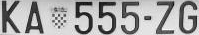

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete[[[[0, 0], [199, 0], [199, 35], [0, 35]], 'KA 555-Z6']]
AHA236.png 

4
ar =  4.25 , shape =  circle


ar =  4.08 , shape =  circle


ar =  4.08 , shape =  circle


ar =  2.108108108108108 , shape =  circle


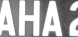

[[[[0, 0], [78, 0], [78, 37], [0, 37]], 'AHAZ']]
WVS7250.jpg 

4
ar =  4.333333333333333 , shape =  pentagon


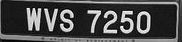

[[[[21, 3], [157, 3], [157, 41], [21, 41]], 'WVS 7250']]
MCG7722.png 

4
ar =  4.442622950819672 , shape =  rectangle


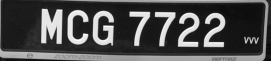

[[[[34, 2], [232, 2], [232, 54], [34, 54]], 'MCG 7722']]
MCC86.png 

4
ar =  3.7567567567567566 , shape =  rectangle


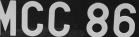

[[[[0, 0], [139, 0], [139, 37], [0, 37]], 'MCC 86']]
PEN15.jpg 

4
ar =  1.6923076923076923 , shape =  rectangle


ar =  2.8125 , shape =  circle


[[[[0, 0], [45, 0], [45, 16], [0, 16]], 'PEN 15']]
HWD3092.jpg 

4
ar =  4.777777777777778 , shape =  pentagon


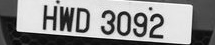

[[[[34, 0], [172, 0], [172, 45], [34, 45]], 'HWD 3092']]
1.JPG 

4
ar =  2.096774193548387 , shape =  rectangle


[[[[7, 7], [57, 7], [57, 27], [7, 27]], 'RRNO895']]
2.JPG 

4
ar =  3.263157894736842 , shape =  rectangle


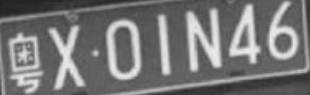

[[[[-3, -9], [311, -9], [311, 102], [-3, 102]], '@X 0IN46]']]
3.JPG 

4
ar =  5.466666666666667 , shape =  rectangle


[[[[14, 0], [140, 0], [140, 28], [14, 28]], '523 3108']]
4.JPG 

4
ar =  5.4523809523809526 , shape =  rectangle


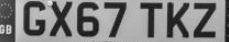

[[[[16, 0], [226, 0], [226, 42], [16, 42]], 'GX67 TKZ']]
5.JPG 

4
ar =  3.4105263157894736 , shape =  rectangle


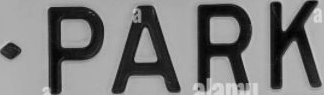

[[[[0, 0], [324, 0], [324, 95], [0, 95]], 'APARK']]
6.JPG 

4
ar =  6.0 , shape =  circle


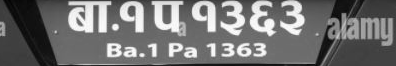

[[[[60, 0], [396, 0], [396, 62], [60, 62]], '41.949383alamy Ba.1 Pa 1363']]
7.JPG 

4
ar =  1.451063829787234 , shape =  rectangle


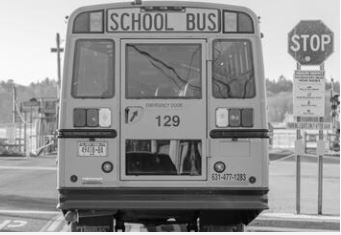

[[[[104, 8], [222, 8], [222, 36], [104, 36]], 'ESCHOOL_BuS]'], [[[284, 30], [336, 30], [336, 56], [284, 56]], '(STOP'], [[[151, 111], [183, 111], [183, 129], [151, 129]], '129']]


In [8]:
for x in list(store_dict.keys()):
    print(x,'\n')
    temp = store_dict[x]
    max_iter = generate_important_roi_2(temp)
    	
    
    idx = generate_df_prob(max_iter)
    len_idx = len(idx)
    print(len_idx)
    while len_idx > -1:
      
      indx = idx.iloc[len(idx) - (len_idx)]['index']
      
      lp = temp['iteration_'+str(indx)]
      print("ar = ",lp[0],', shape = ',lp[1])
      
      
      grayImage = cv2.cvtColor(lp[4], cv2.COLOR_BGR2GRAY)
      cv2_imshow(grayImage)
      reader = easyocr.Reader(['en'])
      result = reader.readtext(grayImage,paragraph="False")
      if len(result) > 0:
        print(result)
        break
      len_idx-=1